# Part 1: Decision Trees for Classification

Before we begin the question, let's implement the classification tree class and related functions to deal with the data.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
def generaterow(sigma):
    row = []
    for _ in range(15): # adds x's
        row.append(-1 if int(round(np.random.rand()))==0 else 1)
    
    function = 0.9*row[0] + (0.9**2)*row[1] + (0.9**3)*row[2] + (0.9**4)*row[3] + (0.9**5)*row[4] + np.random.normal(loc=0, scale=sigma)
    
    row.append(int(np.sign(function))) # adds y

    return row

In [20]:
generaterow(1)

[-1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1]

In [21]:
def initDataframe():
    columns = [f'x{i}' for i in range(1,16)]
    columns.append('y')

    df = pd.DataFrame(columns=columns)
    return df

In [22]:
def populateDataframe(df, rows, alpha):
    for i in range(rows):
        df.loc[len(df.index)] = generaterow(alpha)
    
    return df

In [23]:
class ClassificationTree:
    def __init__(self, numpdf, left=None, right=None): 
        self.df = numpdf # self.df is a numpy array NOT pandas dataframe
        self.left = left
        self.right = right
        self.bestfeature = -1

    def split(self):
        if self.df[(self.df[:,-1]==-1),:].shape[0] == 0 or self.df[(self.df[:,-1]==1),:].shape[0] == 0:
            return (None, None) # pure node, y is either all -1 or +1

        best = self.findbestfeature()
        leftdata = self.df[self.df[:,best] == -1]
        rightdata = self.df[self.df[:,best] == 1]
        return (leftdata, rightdata)

    def findbestfeature(self):
        bestfeatureIG = -1
        for featurenumber in range(self.df.shape[1]-1): # number of columns (0-14)
            if self.informationgain(featurenumber) > bestfeatureIG:
                bestfeatureIG = self.informationgain(featurenumber)
                self.bestfeature = featurenumber
        
        return self.bestfeature


    def informationgain(self, featurenumber):
        return self.entropyY() - self.entropyYgivenX(featurenumber)
        

    def entropyY(self):
        ent = 0
        for i in [-1,1]:
            probi = self.df[(self.df[:,-1]==i),:].shape[0] / self.df.shape[0] 
            ent += probi * np.log2(probi)

        return ent*-1


    def entropyYgivenX(self, featurenumber):
        ent = 0
        # featurenumber = int(feature[-1]) - 1 # just turning the feature string into an index. (ex: 'x1' -> 0)
        for i in [-1,1]: # iterate over x
            numberofxiequalsx = self.df[(self.df[:,featurenumber]==i),:].shape[0]

            if numberofxiequalsx == 0: # check if feature is all either -1 or +1
                return self.entropyY() # this will make the IG zero

            pxeqx = numberofxiequalsx / self.df.shape[0]
            pysum = 0

            for j in [-1,1]: # iterate over y
                pyeqyxeqx = self.df[(self.df[:,-1]==j) & (self.df[:,featurenumber] == i)].shape[0] / numberofxiequalsx
                
                with np.errstate(divide='raise'): # allows us to handle case where p(y=y|x=x) is 0
                    try:
                        pysum += pyeqyxeqx*np.log2(pyeqyxeqx)*-1
                    except FloatingPointError:
                        pysum += 0
            
            ent += pxeqx * pysum
        
        return ent


In [24]:
def buildtree(treehead, minsamplesize): # recursively builds tree from head
    if treehead.df.shape[0] <= minsamplesize: # checks if node is below minimum sample size
        return
    
    leftdata, rightdata = treehead.split()
    if leftdata is None or rightdata is None: return # checks for pure node

    if leftdata.shape[0] < minsamplesize or rightdata.shape[0] < minsamplesize: return # don't split

    treehead.left = ClassificationTree(leftdata)
    buildtree(treehead.left, minsamplesize)

    treehead.right = ClassificationTree(rightdata)
    buildtree(treehead.right, minsamplesize)


In [25]:
def inordertraversal(treehead): # to view the tree
    if treehead is None:
        return 

    print('(', end='')
    inordertraversal(treehead.left)
    print(treehead.df.shape[0], end='')
    inordertraversal(treehead.right)
    print(')', end='')


In [26]:
def trackdatapoint(treehead, datapoint): 
    if treehead.left is None or treehead.right is None: # leaf
        negative = treehead.df[(treehead.df[:,-1]==-1),:].shape[0]
        positive = treehead.df[(treehead.df[:,-1]==1),:].shape[0]
        # print(negative)
        # print(positive)
        # print(negative>positive)
        if negative>positive: return -1 # majority
        if positive>=negative: return 1
    
    if datapoint[treehead.bestfeature] == -1: 
        # print("going left")
        return trackdatapoint(treehead.left, datapoint)
    if datapoint[treehead.bestfeature] == 1: 
        # print("going right")
        return trackdatapoint(treehead.right, datapoint)

In [27]:
def error(treehead, dataframe):
    error = 0
    for i in range(dataframe.shape[0]): # rows
        if dataframe[i][-1] != trackdatapoint(treehead, dataframe[i]):
            error += 1
        # print("\t")
    
    error /= dataframe.shape[0]
    return error

In [28]:
# Creating train/test data
traindat = initDataframe()
traindat = populateDataframe(traindat, 5000, 0.05)
traindat = traindat.to_numpy()

testdat = initDataframe()
testdat = populateDataframe(testdat, 500, 0.05)
testdat = testdat.to_numpy()

In [29]:
treehead = ClassificationTree(traindat)
buildtree(treehead, 300)

In [30]:
inordertraversal(treehead)

((((644)1233(589))2499(((326)638(312))1266((307)628(321))))5000((((319)638(319))1272((317)634(317)))2501((606)1229(623))))

In [31]:
treehead.df

array([[ 1, -1, -1, ..., -1, -1,  1],
       [ 1, -1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1, -1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1, -1,  1, ..., -1,  1,  1],
       [ 1,  1, -1, ...,  1,  1,  1]], dtype=int64)

In [32]:
xvals = np.arange(1,2000,10)
testerrorvals = np.zeros(xvals.shape[0])
trainerrorvals = np.zeros(xvals.shape[0])
optimalsamplesize = 0

for i,v in enumerate(xvals):
    treehead = ClassificationTree(traindat)
    buildtree(treehead, v)
    # inordertraversal(treehead)
    testerrorvals[i] = error(treehead, testdat)
    trainerrorvals[i] = error(treehead, traindat)

    if testerrorvals[i]==0:
        optimalsamplesize = v

    # print(optimalsamplesize, testerrorvals[i])


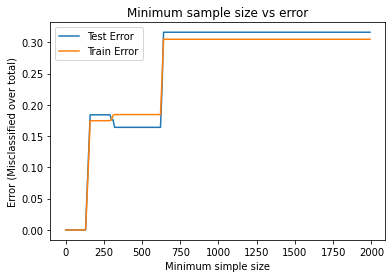

In [33]:
plt.figure()
plt.plot(xvals, testerrorvals, label='Test Error')
plt.plot(xvals, trainerrorvals, label='Train Error')
plt.title("Minimum sample size vs error")
plt.xlabel("Minimum simple size")
plt.ylabel("Error (Misclassified over total)")
plt.legend(loc="upper left")
plt.show()

According to my data, it seems like the optimal sample size is around 115-125, as after that, the error sharply shoots up.

2) After several runs of the code, it seems consistent that this is a good range for the optimal sample size.

I ran the code 5 times and manually collected the optimal sample size recorded during each iteration:
[131, 131, 131, 131, 131], which looks pretty consistent.
The average is 131, so we'll call that s.

In [680]:
optimalsamplesize

131

### Sigma vs error 

In [477]:
optimalS = 131

traindat2 = initDataframe()
traindat2 = populateDataframe(traindat2, 5000, 0)
traindat2 = traindat2.to_numpy()

testdat2 = initDataframe()
testdat2 = populateDataframe(testdat2, 500, 0)
testdat2 = testdat2.to_numpy()

In [478]:
def changeY(dataframe, newsigma):
    for row in dataframe:
        function = 0.9*row[0] + (0.9**2)*row[1] + (0.9**3)*row[2] + (0.9**4)*row[3] + (0.9**5)*row[4] + np.random.normal(loc=0, scale=newsigma)
        row[-1] = int(np.sign(function))

In [479]:
def checkunnecessaryfeatures(treehead):
    ufeatures = [5,6,7,8,9,10,11,12,13,14]
    if treehead is None:
        return 0
    else:
        return checkunnecessaryfeatures(treehead.left)+checkunnecessaryfeatures(treehead.right)+1

In [480]:
sigmavals = np.linspace(0,4,30)
testerror2vals = np.zeros(sigmavals.shape[0])
trainerror2vals = np.zeros(sigmavals.shape[0])
unnfeaturesvals = np.zeros(sigmavals.shape[0])

for i,v in enumerate(sigmavals): # iterates over sigmas
    treehead = ClassificationTree(traindat2)
    buildtree(treehead, optimalS)
    # inordertraversal(treehead)
    testerror2vals[i] = error(treehead, testdat2)
    trainerror2vals[i] = error(treehead, traindat2)
    unnfeaturesvals[i] = checkunnecessaryfeatures(treehead)
    changeY(testdat2, v)
    changeY(traindat2, v)

    print(v)

0.0
0.13793103448275862
0.27586206896551724
0.41379310344827586
0.5517241379310345
0.6896551724137931
0.8275862068965517
0.9655172413793103
1.103448275862069
1.2413793103448276
1.3793103448275863
1.5172413793103448
1.6551724137931034
1.793103448275862
1.9310344827586206
2.0689655172413794
2.206896551724138
2.3448275862068964
2.4827586206896552
2.6206896551724137
2.7586206896551726
2.896551724137931
3.0344827586206895
3.1724137931034484
3.310344827586207
3.4482758620689653
3.586206896551724
3.7241379310344827
3.862068965517241
4.0


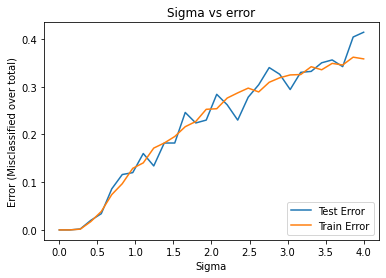

In [481]:
plt.figure()
plt.plot(sigmavals, testerror2vals, label='Test Error')
plt.plot(sigmavals, trainerror2vals, label='Train Error')
plt.title("Sigma vs error")
plt.xlabel("Sigma")
plt.ylabel("Error (Misclassified over total)")
plt.legend(loc="lower right")
plt.show()

3) Noise clearly makes the model perform much worse, even at our previously calculated optimal sample size when the sigma was held constant. The optimal sample size would have to be much lower for higher values of sigma, as the model would need to be much more specific with how it's classifying the data.

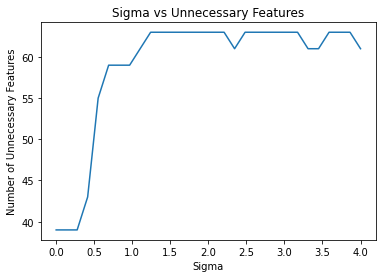

In [482]:
plt.figure()
plt.plot(sigmavals, unnfeaturesvals)
plt.title("Sigma vs Unnecessary Features")
plt.xlabel("Sigma")
plt.ylabel("Number of Unnecessary Features")
plt.show()

4) It seems like the amount of noise increases the number of unnecessary features in the model drastically. These features still show up in the model even with no noise, but this can be attributed to the fact that the data is very repetitive, being completely binary. It makes sense for repeats and whatnot to affect the model's quality. This result is also consistent with my answer for 3, as the greater number of unnecessary features involved in the model, the greater likelihood it is for the model to misclassify datapoints.

# Part 2: Logistic Regression

In [78]:
def trackdatapointsoft(treehead, datapoint): 
    if treehead.left is None or treehead.right is None: # leaf
        negative = treehead.df[(treehead.df[:,-1]==-1),:].shape[0]
        positive = treehead.df[(treehead.df[:,-1]==1),:].shape[0]
        return positive/(positive+negative) # soft classification
    
    if datapoint[treehead.bestfeature] == -1: 
        # print("going left")
        return trackdatapointsoft(treehead.left, datapoint)
    if datapoint[treehead.bestfeature] == 1: 
        # print("going right")
        return trackdatapointsoft(treehead.right, datapoint)

In [83]:
def logisticerror(treehead, dataframe):
    error = 0
    for i in range(dataframe.shape[0]): # rows
        yi = dataframe[i][-1]
        if yi == -1: # changing -1/+1 to 0/1
            yi = 0
        # to avoid log 0 errors
        if trackdatapointsoft(treehead, dataframe[i]) == 0 and yi == 0: 
            error += 0
        elif trackdatapointsoft(treehead, dataframe[i]) == 0 and yi == 1: 
            error += 1
        elif trackdatapointsoft(treehead, dataframe[i]) == 1 and yi == 0: 
            error += 1
        elif trackdatapointsoft(treehead, dataframe[i]) == 1 and yi == 1: 
            error += 0
        else:
            error += (-1)*yi*np.log(trackdatapointsoft(treehead, dataframe[i])) - (1-yi)*np.log(1-trackdatapointsoft(treehead, dataframe[i]))
        
    error /= dataframe.shape[0]
    return error

In [75]:
traindat3 = initDataframe()
traindat3 = populateDataframe(traindat3, 5000, 0)
traindat3 = traindat3.to_numpy()

testdat3 = initDataframe()
testdat3 = populateDataframe(testdat3, 500, 0)
testdat3 = testdat3.to_numpy()

In [73]:
sam = ClassificationTree(traindat3)
buildtree(sam, 601)
print(trackdatapointsoft(sam, testdat3[3]))
# samtree is None
sam.right.left.right.df[sam.right.left.right.df[:,-1]==-1].shape

going right
going left
going right
0.7594752186588921


(165, 16)

In [496]:
samplevals = np.arange(1,1000,10)
testerror3vals = np.zeros(samplevals.shape[0])
trainerror3vals = np.zeros(samplevals.shape[0])

for i,v in enumerate(samplevals):
    treehead = ClassificationTree(traindat3)
    buildtree(treehead, v)
    # inordertraversal(treehead)
    testerror3vals[i] = logisticerror(treehead, testdat3)
    trainerror3vals[i] = logisticerror(treehead, traindat3)

    if testerrorvals[i]==0:
        optimalsamplesizel = v

    # print(v, end=' ')

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

In [497]:
optimalsamplesizel

131

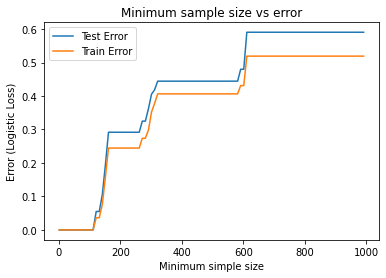

In [498]:
plt.figure()
plt.plot(samplevals, testerror3vals, label='Test Error')
plt.plot(samplevals, trainerror3vals, label='Train Error')
plt.title("Minimum sample size vs error")
plt.xlabel("Minimum simple size")
plt.ylabel("Error (Logistic Loss)")
plt.legend(loc="upper left")
plt.show()

1) The optimal sample size turns out to be the exact same as the one in the hard classifying trees, 131. For the way I've defined the optimal sample size (the greatest size for which the error is 0 on the test data), this makes sense, as we would expect the trees' leaves to turn nonpure (soft classification) at the same sample size value where the trees' leaves begin to have at least one misclassified input (hard classification). Had I defined the optimal sample size more leniently, it would've been different for the two. This is clear especially after comparing the graphs for both: soft classification is more forgiving for higher minimum sample sizes.

Logistic Regression with SGD

In [197]:
def sigmoid(w, x): #
    dot = np.dot(w,x)
    return 1 / (1 + np.exp(-1*dot))

In [222]:
def logisticerrorregression(wvec, xmatr, yvec):
    error = 0
    for i in range(xmatr.shape[0]): # for every datapoint
        prediction = sigmoid(wvec, xmatr[i])
        prediction = np.clip(prediction, 10**-6, 1-10**-6) # forces the prediction to not be 0 or 1
        error += (-1)*yvec[i]*np.log(prediction) - (1-yvec[i])*np.log(1-prediction)
    return error/xmatr.shape[0] # returns average error

In [87]:
traindat4 = initDataframe()
traindat4 = populateDataframe(traindat4, 5000, 0)
traindat4 = traindat4.to_numpy()

testdat4 = initDataframe()
testdat4 = populateDataframe(testdat4, 500, 0)
testdat4 = testdat4.to_numpy()

In [239]:
# formatting, setting up X and y for gradient descent
wvector = [0]*16
traindat4[traindat4==-1] = 0
xmatrix = np.array_split(traindat4, indices_or_sections=[15], axis=1)[0]
yvector = np.array_split(traindat4, indices_or_sections=[15], axis=1)[1]
yvector = [i for [i] in yvector]
x0 = [1]*xmatrix.shape[0]
xmatrix = np.insert(xmatrix, 0, x0, axis=1)

# same thing for test data
testdat4[testdat4==-1] = 0
testx = np.array_split(testdat4, indices_or_sections=[15], axis=1)[0]
testy = np.array_split(testdat4, indices_or_sections=[15], axis=1)[1]
testy = [i for [i] in testy]
x0 = [1]*testx.shape[0]
testx = np.insert(testx, 0, x0, axis=1)

In [686]:
print(logisticerrorregression(wvector, xmatrix, yvector))

0.6931471805599917


In [677]:
import time

def SGD(initw, xmatrix, yvector, testx, testy, alpha, errorbound):
    timearray=[] 
    trainerrorarray=[]
    testerrorarray=[]
    start = time.time()
    st = time.time()
    end = time.time()
    while (logisticerrorregression(initw, xmatrix, yvector) > errorbound):
        if end-st > 1: # tracks loss around every second
            timearray.append(end-start)
            trainerrorarray.append(logisticerrorregression(initw, xmatrix, yvector))
            testerrorarray.append(logisticerrorregression(initw, testx, testy))
            st = time.time()

        # chooses random datapoint to perform GD on 
        choice = np.random.randint(0, xmatrix.shape[0]-1)
        initw -= alpha*(sigmoid(initw, xmatrix[choice])-yvector[choice])*xmatrix[choice]
        # print(logisticerrorregression(initw, xmatrix, yvector), timearray)
        end = time.time()
        
    return (initw, timearray, trainerrorarray, testerrorarray)

In [682]:
alpha = 0.1
errorbound = 0.25
wstar, timearray, trainerrorarray, testerrorarray = SGD(wvector, xmatrix, yvector, testx, testy, alpha, errorbound)
print(wstar)

[-2.93059655  1.74707935  1.91566976  2.26126122  1.82362004  1.95481563
 -0.25090147 -0.1061856   0.00937904 -0.64389409 -0.18446272 -0.28090573
 -0.52041031 -0.49556387 -0.46920374 -0.44790491]


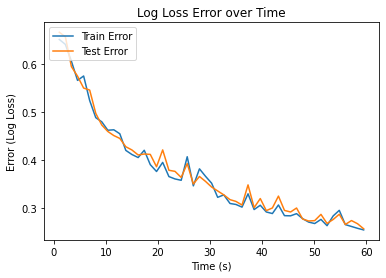

In [683]:
plt.figure()
plt.plot(timearray, trainerrorarray, label='Train Error')
plt.plot(timearray, testerrorarray, label='Test Error')
plt.title("Log Loss Error over Time")
plt.xlabel("Time (s)")
plt.ylabel("Error (Log Loss)")
plt.legend(loc="upper left")
plt.show()

2) Overfitting is definitely not an issue as the test and train errors are very similar. This is somewhat expected. The test and train data are both very similar, as the method of generating these datasets involves only binary data for 15 features, with only a small variance for the error. As the training data had 5000 datapoints, it is within the magnitude of the number of all possible datapoints, meaning that the test and train data are likely to have more or less overlapping datapoints, or are at least very similar. As the model becomes more robust via SGD, it begins to generalize better as well, a fact that can be seen as the small difference between the train and test error at the start of the graph slowly reduces over time. Had I let the gradient descent algorithm run for much longer, then we might see the test error begin to go up slightly.

In [246]:
wstar

array([-2.62278563,  2.04161925,  2.29904304,  1.78683659,  1.99095722,
        2.34191794, -0.37966119, -0.43157242, -0.3576445 , -0.86140906,
       -0.222992  , -0.51542976, -0.67049135, -0.44873966, -0.37940581,
       -0.52964998])

In [687]:
logisticerrorregression(wstar, xmatrix, yvector)

0.24928143366810715

3) For this set of test data, it took the logistic model far more time to train to the same level of logistic error as the classification trees. Additionally, the regression model with the lowest loss still had far higher error than the optimal classification tree (around 0.25 vs 0). Once again, this can be attributed to the fact that the data is very simple and has small variance. Tree models can overfit very quickly when the stopping conditions are too lenient, but for a dataset of this nature, it doesn't matter, as proven by the test and train errors being extremely similar despite the "overfit" trees. Meanwhile, the regression model also has a consistently small difference between train and test error, but it takes longer to reduce the error as it most likely has trouble finding a concrete seperator between such similar data. Of course, this analysis is bound to be different for other sets of data.

# Part 3: Support Vector Machines

In [663]:
svmdata = pd.DataFrame(data={
'x1': [-1, 1, -1, 1],
'x2': [-1, -1, 1, 1],
'y': [-1, 1, 1, -1]
})

In [664]:
svmdata

,x1,x2,y
0,-1,-1,-1
1,1,-1,1
2,-1,1,1
3,1,1,-1


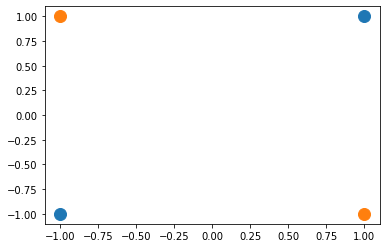

In [665]:
plt.figure()
groups = svmdata.groupby('y')
for name, group in groups:
    plt.plot(group.x1, group.x2, marker='o', linestyle='', markersize=12, label=name)
plt.show()

The data is clearly not linearly separable in this feature space. So, we can use a polynomial kernel to map it onto a higher dimensional feature space and separate the data that way.

In [666]:
xsvmdat = np.array_split(svmdata.to_numpy(), indices_or_sections=[2], axis=1)[0]
ysvmdat = np.array_split(svmdata.to_numpy(), indices_or_sections=[2], axis=1)[1]

In [685]:
# connects to Mathematica so I can use it within my SMO algorithm
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()
session.start()

In [636]:
session.evaluate(wlexpr('''
    findmax[a_, i1e_, i2e_, b1_, b2_] := 
        Module[{temp, x, y, addition, subtract, ep},
        temp = a;
        temp[[i1e + 1]] += ep;
        temp[[i2e + 1]] += ep;
        kernel[x_, y_] := (1 + x . y)^2;
        x = {{-1, -1}, {1, -1}, {-1, 1}, {1, 1}};
        y = {-1, 1, 1, -1};
        addition = Sum[temp[[i]], {i, 1, 4}];
        subtract = 
        Sum[Sum[temp[[i]]*y[[i]]*kernel[x[[i]], x[[j]]]*y[[j]]*
            temp[[j]], {j, 1, 4}], {i, 1, 4}];
        objfunc = addition - 0.5*subtract;
        ep /. Last[FindMaximum[{objfunc, b1 <= ep <= b2}, {ep, 0}]]
        ]
'''))

In [637]:
findepsilon = session.function('findmax')

In [667]:
alphas = [0.125,0,0,0]
maxtweakcycles = 25

def SMO(alphas, xdata, ydata, maxtweakcycles): #stopping condition a certain max number of alpha tweaks
    tweakcycles = 0
    while (tweakcycles<maxtweakcycles):
        for i in range(xdata.shape[0]):
            for j in range(i+1,xdata.shape[0]):
                if ydata[i] == ydata[j]: # both positive or both negative
                    positive = alphas[i]
                    negative = alphas[j]
                    b1 = positive*-1 # lower bound 
                    b2 = negative # upper bound for what epsilon can be (otherwise alphas[j] could be < 0) 
                    # print(alphas, i, j, b1, b2, findepsilon(alphas,i,j,b1,b2),"same")
                    alphas[i] += round(findepsilon(alphas, i, j, b1, b2),3)
                    alphas[j] -= round(findepsilon(alphas, i, j, b1, b2),3)
                    # print(alphas[i],alphas[j])
                    
                elif ydata[i] != ydata[j]: # one positive, one negative
                    positive1 = alphas[i]
                    positive2 = alphas[j]
                    b1 = -1*positive1 if positive1<positive2 else -1*positive2 # lower bound is set to the smaller one
                    b2 = 10 # arbitrary
                    # print(alphas, i, j, b1, b2, findepsilon(alphas,i,j,b1,b2), "diff")
                    alphas[i] += round(findepsilon(alphas, i, j, b1, b2),3)
                    alphas[j] += round(findepsilon(alphas, i, j, b1, b2),3)
                    # print(alphas[i],alphas[j])
        tweakcycles+=1

    return alphas

In [668]:
alphastar = SMO(alphas,xsvmdat,ysvmdat,maxtweakcycles)

In [669]:
alphastar

[0.126, 0.126, 0.126, 0.12400000000000001]

This vector of alphas satisfies both constraints of the Dual SVM problem. As all of the alpha values are nonzero, every datapoint should be a support vector. Now we can find the separator using the equations w dot x = sum over the vectors of alphai\*yi\*Kernel(xi*X), and b = yi-wdotx.

<img src="finalfunc.png" width=500>

So the final equation for the nonlinear separator is sign(-x1*x2). We can graph it on desmos to see if it makes sense.

<img src="graph.png" width=800>

This looks good: it classifies the points correctly, is clearly nonlinear, and all of the points are support vectors as the alpha values suggested.